In [82]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import cv2
import albumentations
from os import listdir
from os.path import isfile, join, splitext
import glob
import numpy as np
print(tf.__version__)

2.10.0


In [83]:
image_size = (96, 96)
batch_size = 128

In [84]:
transform = albumentations.Compose([
    albumentations.Rotate(limit=(-5,5),p=0.1),
    albumentations.RandomResizedCrop (height=image_size[0],width=image_size[1],scale=(0.3,1.1),p=0.2),
    albumentations.HorizontalFlip(p=0.2),
    albumentations.RandomBrightnessContrast(p=0.2)
])

In [85]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_names, labels, batch_size=64, dim=(96,96), n_channels=1, n_classes=2, shuffle=True):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_names = list_names
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_names) / self.batch_size))
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_names[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp,indexes)
        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp,indexes):
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        try:
            for i, (ind, ID) in enumerate(zip(indexes,list_IDs_temp)):
                img = cv2.imread(ID,0)  # BGR
                transformed = transform(image=img)
                transformed_image = transformed["image"]
                img = cv2.resize(transformed_image, self.dim)
                X[i,] = np.asarray(img, dtype=np.uint8)
                y[i] = self.labels[ind]
        except:
            print(list_IDs_temp)

        return X, y

In [86]:
folder_1 = r"C:\Users\const\OneDrive\Desktop\images\bear"

image_files_1= []
labels_1 = []
only_files = [f for f in listdir(folder_1) if isfile(join(folder_1, f))]
for o in only_files:
    adress = join(folder_1, o)
    filename, file_extension = splitext(adress)
    image_files_1.append(adress)
    labels_1.append(0)

folder_2 = r"C:\Users\const\OneDrive\Desktop\images\nobear"

image_files_2= []
labels_2 = []
only_files = [f for f in listdir(folder_2) if isfile(join(folder_2, f))]
for o in only_files:
    adress = join(folder_2, o)
    filename, file_extension = splitext(adress)
    image_files_2.append(adress)
    labels_2.append(1)

In [87]:
c1 = int(len(image_files_1)/5) #20% of data as test
c2 = int(len(image_files_2)/5)

images_data_train = image_files_1[:c1]+image_files_2[:c2]
images_data_test = image_files_1[c1:]+image_files_2[c2:]

labels_data_train = labels_1[:c1]+labels_2[:c2]
labels_data_test = labels_1[c1:]+labels_2[c2:]

DataTrain = DataGenerator(images_data_train,labels_data_train,dim=image_size,batch_size=batch_size)
DataTest = DataGenerator(images_data_test,labels_data_test,dim=image_size,batch_size=32)

In [90]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    tf_model = tf.keras.applications.MobileNet(input_shape=(96, 96, 3), alpha=0.25, include_top=False)

    x = tf.keras.layers.Conv2D(3, (1, 1), padding='same', use_bias=False,
                               strides=(1, 1))(inputs)

    x = tf_model(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(2, (1, 1), padding='same', use_bias=False,
                               strides=(1, 1),activation="sigmoid")(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Reshape((2,))(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=inputs, outputs=out)
    return model


model = make_model(input_shape=image_size + (1,), num_classes = 2)


Epoch 1/30
1/1 [==============================] - 35s 35s/step - loss: 0.6461 - accuracy: 0.6172 - val_loss: 0.6854 - val_accuracy: 0.5284
Epoch 2/30
1/1 [==============================] - 28s 28s/step - loss: 0.4998 - accuracy: 0.8750 - val_loss: 0.6764 - val_accuracy: 0.5511
Epoch 3/30
1/1 [==============================] - 28s 28s/step - loss: 0.4469 - accuracy: 0.9062 - val_loss: 0.6662 - val_accuracy: 0.5511
Epoch 4/30
1/1 [==============================] - 28s 28s/step - loss: 0.3710 - accuracy: 0.9766 - val_loss: 0.6573 - val_accuracy: 0.5582
Epoch 5/30
1/1 [==============================] - 28s 28s/step - loss: 0.3524 - accuracy: 0.9766 - val_loss: 0.6593 - val_accuracy: 0.5597
Epoch 6/30
1/1 [==============================] - 28s 28s/step - loss: 0.3291 - accuracy: 1.0000 - val_loss: 0.6369 - val_accuracy: 0.5852
Epoch 7/30
1/1 [==============================] - 27s 27s/step - loss: 0.3297 - accuracy: 0.9922 - val_loss: 0.6274 - val_accuracy: 0.6122
Epoch 8/30
1/1 [===========

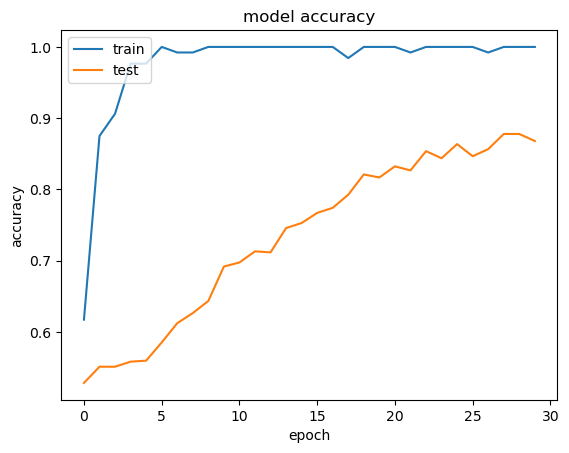

In [91]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    DataTrain, epochs=epochs, callbacks=callbacks, validation_data=DataTest,
)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('model', save_format='h5')

In [92]:
image_folder = r"C:\Users\const\OneDrive\Desktop\images\calibration"
img_path = glob.glob(image_folder+r"\*")
validation_data_set=[]
for file_name in img_path:
    img = cv2.imread(file_name,0) #BGR
    img = cv2.resize(img,(96, 96))
    #img = img[:,:,::-1]
    ary = np.asarray(img, dtype=np.float32)
    ary = np.expand_dims(ary, axis=0)
    ary = np.expand_dims(ary, axis=3)
    validation_data_set.append(ary)

In [93]:
def representative_dataset():
    for _ in range(100):
        data = 127*np.random.rand(1, 96, 96)
        yield [data.astype(np.float32)]

def representative_dataset_gen():
    for i in range(len(validation_data_set)):
        yield [validation_data_set[i]]

def port(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    tflite_model = converter.convert()
    with open('model.tflite', 'wb') as f:
        f.write(tflite_model)

In [94]:
model = keras.models.load_model('save_at_30.h5')
port(model)

INFO:tensorflow:Assets written to: C:\Users\const\AppData\Local\Temp\tmpc1qnl0jx\assets


INFO:tensorflow:Assets written to: C:\Users\const\AppData\Local\Temp\tmpc1qnl0jx\assets
C:\Users\const\anaconda3\envs\IoT\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'xxd' is not recognized as an internal or external command,
operable program or batch file.
'cat' is not recognized as an internal or external command,
operable program or batch file.
